# The Realm of Supervised Learning
- In this Notebook we will focus on below topics 

<table allign='left'>
<tr><td>1. Preprocessing data using different techniques</td><td>2 Label encoding</tr>
<tr><td>3. Building a linear regressor </td> <td>4. Computing regression accuracy</td></tr>
<tr><td>5. Achieving model persistence</td><td>6. Building a ridge regressor</tr>
<tr><td>7. Building a polynomial regressor</td><td>8. Estimating housing prices</tr>
<tr><td>9. Computing the relative importance of features</td><td>10. Estimating bicycle demand distribution</tr>
</table>

   
    
    
    
    
    
    
    
    
    

## Recap of Supervised learning 
- Supervised learning is a method of machile learning where the input data is labelled. i.e we will have the data examples available Ex: House Price prediction. In other words, we will teach the Machine on some data and then ask for the data that we dont know the value for(new examples or queries). <a href='http://www.holehouse.org/mlclass/01_02_Introduction_regression_analysis_and_gr.html'> More info </a>

In [208]:
# Import all required Libraries here
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import PolynomialFeatures
import re
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import datasets
from sklearn.utils import shuffle
import sklearn.metrics as sm
from sklearn.cross_validation import train_test_split
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns  
import cPickle as pickle
import warnings
import csv

# For visualization purposes 
%matplotlib inline
sns.set()

### 1: Preprocessing data
- Before we work on any data we need to process the data, so that the model will predict us the better results and have best performance. 

In [2]:
# Example Demonstration on how Preprocessing works
data = np.array([[3, -1.5,  2, -5.4], [0,  4,  -0.3, 2.1], [1,  3.3, -1.9, -4.3]])
print 'Original Data\n', data
print '*'* 40
# Mean removal method - This substracts the mean from the data so the data is centered to zero
data_standardized = preprocessing.scale(data) 
print 'Mean=', data_standardized.mean(axis=0)
print '*'* 40
print 'Std=', data_standardized.std(axis=0)

Original Data
[[ 3.  -1.5  2.  -5.4]
 [ 0.   4.  -0.3  2.1]
 [ 1.   3.3 -1.9 -4.3]]
****************************************
Mean= [  5.55111512e-17  -1.11022302e-16  -7.40148683e-17  -7.40148683e-17]
****************************************
Std= [ 1.  1.  1.  1.]


- We can observe that the mean is almost equal to zero and there is not much deviation in the data

#### Scale 
Sometimes it is important to scale the data within a data range , below will demostrate it. 

In [3]:
data_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
print 'Min Max Scaled data \n', data_scaler.fit_transform(data)

Min Max Scaled data 
[[ 1.          0.          1.          0.        ]
 [ 0.          1.          0.41025641  1.        ]
 [ 0.33333333  0.87272727  0.          0.14666667]]


#### Normalize 

In [4]:
# adjusts the values of a feature vector so that they sum up to 1
print 'Normalized Data= \n', preprocessing.normalize(data, norm = 'l1')

Normalized Data= 
[[ 0.25210084 -0.12605042  0.16806723 -0.45378151]
 [ 0.          0.625      -0.046875    0.328125  ]
 [ 0.0952381   0.31428571 -0.18095238 -0.40952381]]


#### Binarization
Used to convert numerical features to boolean vectors 

In [5]:
print "Binarized Data=\n" , preprocessing.Binarizer(threshold=1.4).transform(data)

Binarized Data=
[[ 1.  0.  1.  0.]
 [ 0.  1.  0.  1.]
 [ 0.  1.  0.  0.]]


### 2: Label Encoding
- if the label names are numeric then the algorithm can use them directly, But most of the times as we need to understand the data we will have it in words, And we will use Label Encoding too transform the word labels into numerical Form. 

In [6]:
# Lets define the label encoder
labelEncoder = preprocessing.LabelEncoder()
# LabelEncoder object will now understand our labels
input_classes =['audi', 'ford', 'audi', 'toyota', 'ford', 'bmw']
# Encode the labels
labelEncoder.fit(input_classes)

for i, item in enumerate(labelEncoder.classes_):
    print item, '-->', i

audi --> 0
bmw --> 1
ford --> 2
toyota --> 3


As shown above it just sorted based on the ascending order of the label. Now we can try to transform any label as below.

In [7]:
labels = ['toyota', 'ford', 'audi']
encoded_lables = labelEncoder.transform(labels)
print labels
print list(encoded_lables)

['toyota', 'ford', 'audi']
[3, 2, 0]


In [8]:
# we can also do inverse transformation/decoding the labesl
decoded_labels = labelEncoder.inverse_transform(list(encoded_lables))
print decoded_labels

['toyota' 'ford' 'audi']


### 3: Building a Linear Regressor
- Linear Regression is a model of supervised learning, where the hypothesis is generally a straight line/plane. Our goal is to estimate this hypothesis function. $ h_\theta(x) = \theta_0x_0 + \theta_1x_1 + \theta_2x_2 + ... \theta_nx_n $ , Where $ h_\theta(x) $ is representation of the hypothesis function (or the linear function in this case) , parameters $ \theta_0... \theta_n $ are the weights of the function. And $ x_0...x_n $ are the features our our model. 

Our Model will predict the values that suit the best for $\theta_0 ... \theta_n $ which will fit the model. 

In [9]:
# Lets visualize what we are talking here :) 
f = open('data_singlevar.txt','r')
data = f.read().split('\n')
X = []
y = []
data.pop()
for rec in data:
    X.append(float(rec.split(',')[0]))
    y.append(float(rec.split(',')[1]))

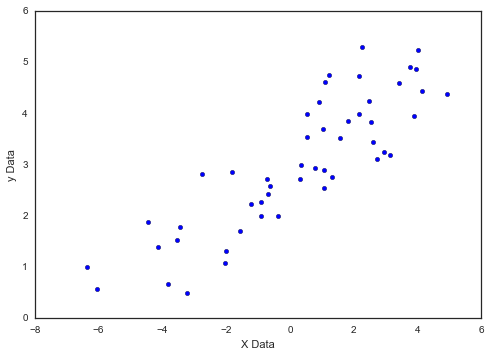

In [10]:
with sns.axes_style('white'):
    plt.scatter(X,y)
    plt.xlabel('X Data')
    plt.ylabel('y Data')

- We can observe the data distribution here it grows on y as x increases but not necessarrily always , so we will just try to plot a line which fits best with the data. 
- Now the real problem comes up to find the value of $ \theta $ vector (i.e $ [ \theta_0 ... \theta_n] ) $

We will use Certain algorithm called as Gradient descent (Just to understand how in general the regressor works ), This algorithm will calculate for each point , the square error averaged by the total number of examples . 
    
> $ J(\theta) =  \dfrac{1}{2m}  \sum_{i=1}^{m}(h_\theta(x^i)-y^i) ^2 $

Our objective of the gradient descent is to minimize the cost for above function.. 
Repeat until Convergence 
$   { \theta_j = \theta_j - \alpha * \frac{\partial J(\theta)}{\partial \theta_j} }    $
where:
$ j = 0,1...n $ For 'n' features 
$ \frac{\partial J(\theta)}{\partial \theta_j} $ is partial derivative for cost function

- By Applying calculus  
Repeat until Convergence 
$   { \theta_j = \theta_j - \alpha * \frac{1}{m}* \sum_{i=1}^{m}(h_\theta(x^i)-y^i) x_j^i }    $
where:
$ j = 0,1...n $ For 'n' features      ,    $\alpha $ is the learning rate.                         


#### However we dont technically dont need to do much of this work as we already have beautiful library sklear which will do the work for us.
    So lets see how to Apply sklearn.linear_model now 


In [11]:
# We have already imported the libraries , data is available in X and y 
# We always need to validate our model, so we need to split the data into test data and train data respecively. 
num_training = int(0.8 * len(X))  # 80% of data
num_test = len(X) - num_training  # remaining data

# Training data
X_train = np.array(X[:num_training]).reshape((num_training,1))
y_train = np.array(y[:num_training])

# Test data
X_test = np.array(X[num_training:]).reshape((num_test,1))
y_test = np.array(y[num_training:])

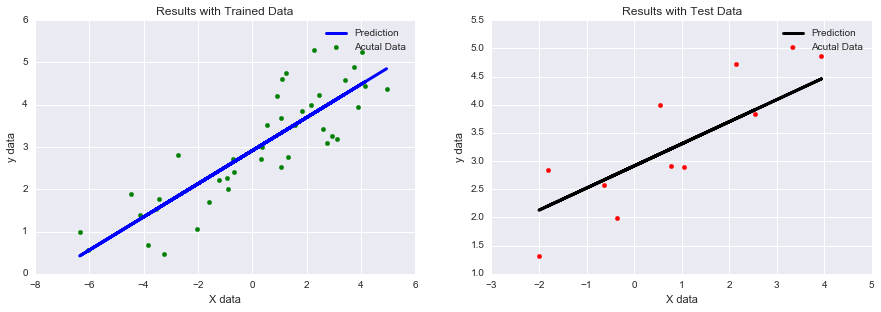

In [12]:
# Now that we have split the data into both training and test we can try to fit this to the model. 
# Create linear model object
linearModel = linear_model.LinearRegression()
# fit the model to test data
linearModel.fit(X_train,y_train)

# Lets see what it predicts for the train set & Plot 
y_train_pred = linearModel.predict(X_train)
y_test_pred = linearModel.predict(X_test)
plt.figure(figsize=(15,10))
plt.subplot(2,2,1)
plt.scatter(X_train, y_train, color='green',label='Acutal Data')
plt.plot(X_train, y_train_pred, linewidth=3, color= 'blue',label='Prediction')
plt.xlabel('X data'); plt.ylabel('y data')
plt.legend()
plt.title('Results with Trained Data')
plt.subplot(2,2,2)
plt.scatter(X_test, y_test, color='red',label='Acutal Data')
plt.plot(X_test, y_test_pred, linewidth=3, color= 'black',label='Prediction')
plt.xlabel('X data'); plt.ylabel('y data')
plt.legend()
plt.title('Results with Test Data')

We can see that both the train and test data fit the model at its best but not very accurately, as there is still a lot deviation for some data. Following below will give us the regression accuracy. 

### 4: Computing Regression Accuracy
An error is defined as the difference between the actual value and the value that is predicted by the regressor. Just like the cost function $ J(\theta) $

- Mean absolute error: This is the average of absolute errors of all the datapoints in the given dataset.
- Mean squared error: This is the average of the squares of the errors of all the datapoints in the given dataset. It is one of the most popular metrics out there!
- Median absolute error: This is the median of all the errors in the given dataset. The main advantage of this metric is that it's robust to outliers. A single bad point in the test dataset wouldn't skew the entire error metric, as opposed to a mean error metric.
- Explained variance score: This score measures how well our model can account for the variation in our dataset. A score of 1.0 indicates that our model is perfect.
- R2 score: This is pronounced as R-squared, and this score refers to the coefficient of determination. This tells us how well the unknown samples will be predicted by our model. The best possible score is 1.0, and the values can be negative as well.

In [13]:
print "Mean absolute error =", round(sm.mean_absolute_error(y_test, y_test_pred), 2) 
print "Mean squared error =", round(sm.mean_squared_error(y_test, y_test_pred), 2) 
print "Median absolute error =", round(sm.median_absolute_error(y_test, y_test_pred), 2) 
print "Explained variance score =", round(sm.explained_variance_score(y_test, y_test_pred), 2) 
print "R2 score =", round(sm.r2_score(y_test, y_test_pred), 2)

Mean absolute error = 0.54
Mean squared error = 0.38
Median absolute error = 0.54
Explained variance score = 0.68
R2 score = 0.68


In [14]:
# we can see that the model is about just 60% accurate
# Another metric which we can use is the score method on the model
print 'Score of our Linear Model(Training) = ', linearModel.score(X_train,y_train) 
print 'Score of our Linear Model(Test Data) = ', linearModel.score(X_test,y_test) 

Score of our Linear Model(Training) =  0.744642664317
Score of our Linear Model(Test Data) =  0.675158663388


It is Obvious that the model works good on the training data rather than the test(new examples/samples).  
A good practice is to make sure that the mean squared error is low and the explained variance score is high.

### 5: Achieving Model Persistance
It is a good practice to save the model for future references instead of creating the model and training it each time, we will use the module cPickle for the same purposes ( Already imported) 

In [15]:
with open('linearRegressor.pkl','w') as f:
    pickle.dump(linearModel, f)

In [16]:
# the regressor model will be saved as linearRegressor.pkl , lets see how to load it and reuse it
with open('linearRegressor.pkl','r') as f:
    modelLin = pickle.load(f)
# and then this model predictions will be same as our existing model, ofcourse it is just a copy of this model
modelLin.predict(X_test) == linearModel.predict(X_test)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

****
### 6: Building a Ridge Regressor
As we have seen the Linear regressor model is not very accurate, And It is not widely used in production due to the metrics that we have seen before, because the regressor is always trying to predict the data based on linear line/plane. 
Also it wont work with outliers (i.e data points which are far seperate from original data) , these outliers will cause problem to our liner model a lot. <br>
To avoid this, we use regularization where a penalty is imposed on the size of the coefficients. This method is called Ridge Regression.

In [87]:
# Lets load a new dataset which contains multiple variables 
# data = pd.read_csv('data_multivar.txt',header=None)
# X = data.drop(3).astype(float); y = data[3].astype(float)
# mask = np.random.rand(len(X)) >= 0.8
# X_train = X[mask].values
# y_train = y[mask].values
# X_test = X[~mask].values
# y_test = y[~mask].values

# Using numpy 
filename = 'data_multivar.txt'
X = []
y = []
with open(filename, 'r') as f:
    for line in f.readlines():
        data = [float(i) for i in line.split(',')]
        xt, yt = data[:-1], data[-1]
        X.append(xt)
        y.append(yt)

# Train/test split
num_training = int(0.8 * len(X))
num_test = len(X) - num_training

# Training data
X_train = np.array(X[:num_training])
y_train = np.array(y[:num_training])

# Test data
X_test = np.array(X[num_training:])
y_test = np.array(y[num_training:])

In [88]:
# Now let us train the model using ridge regressor
ridgeModel = linear_model.Ridge(alpha= 0.01, fit_intercept=True, max_iter=20000)
# The alpha parameter controls the complexity. As alpha gets closer to 0, the ridge regressor tends to become more like a linear regressor with ordinary least squares. 
# So, if you want to make it robust against outliers, you need to assign a higher value to alpha. 
ridgeModel.fit(X_train,y_train)
y_test_pred_ridge = ridgeModel.predict(X_test)
y_train_pred_ridge = ridgeModel.predict(X_train)
print "Mean absolute error =", round(sm.mean_absolute_error(y_test, y_test_pred_ridge), 2) 

print "Mean squared error =", round(sm.mean_squared_error(y_test, y_test_pred_ridge), 2) 
print "Mean squared error(tr) =", round(sm.mean_squared_error(y_train, y_train_pred_ridge), 2) 

print "Median absolute error =", round(sm.median_absolute_error(y_test, y_test_pred_ridge), 2) 
print "Explain variance score =", round(sm.explained_variance_score(y_test, y_test_pred_ridge), 2) 
print "R2 score =", round(sm.r2_score(y_test, y_test_pred_ridge), 2)

Mean absolute error = 3.95
Mean squared error = 23.15
Mean squared error(tr) = 19.68
Median absolute error = 3.69
Explain variance score = 0.84
R2 score = 0.83


In [85]:
ridgeModel.score(X_test,y_test)

0.83448001889970302

In [86]:
# Some how this model is not performing well both on training and test sets if we are using Pandas instead of numpy arrays. 

****
### 7: Building a Polynomial Regressor. 
Linear model doest always fit the data, as the data can be in the form of a curve , so we can change our existing hypothesis by adding polinomial features to it. 
$ h_\theta(x) = \theta_0 x_0 + \theta_1 x_1 + \theta_3 x_0^2 + \theta_4 x_1^2 + \theta_5 x_1 x_2 + ..... $
The curviness of this model is controlled by the degree of the polynomial. As the curviness of the model increases, it gets more accurate. However, curviness adds complexity to the model as well, hence, making it slower. 

In [101]:
# Lets try to create it
polynomial = PolynomialFeatures(degree= 10)

# We had degree =3 which means it will be computed till x^3  
X_train_transformed = polynomial.fit_transform(X_train)

In [102]:
datapoint = np.array([0.39,2.78,7.11]).reshape(1, -1)
poly_datapoint = polynomial.fit_transform(datapoint)
poly_linear_model = linear_model.LinearRegression()
poly_linear_model.fit(X_train_transformed, y_train)
linearModel = linear_model.LinearRegression()
linearModel.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [103]:
poly_datapoint.shape,X_train_transformed.shape

((1L, 286L), (400L, 286L))

In [104]:
print "\nLinear regression:", linearModel.predict(datapoint)
print "\nPolynomial regression:", poly_linear_model.predict(poly_datapoint)


Linear regression: [-11.0587295]

Polynomial regression: [-8.14893471]


In [107]:
# As we keep on increasing the degree of the model the accuracy will improve. This is result of further bend in the curve
poly_linear_model.score(X_train_transformed,y_train)

0.95763167919971326

****
### 8: Estimating House Prices. 
We will use a decision tree regressor with AdaBoost to solve this problem. 

A decision tree is a tree where each node makes a simple decision that contributes to the final output. The leaf nodes represent the output values, and the branches represent the intermediate decisions that were made, based on input features. AdaBoost stands for Adaptive Boosting, and this is a technique that is used to boost the accuracy of the results from another system. This combines the outputs from different versions of the algorithms, called weak learners, using a weighted summation to get the final output. The information that's collected at each stage of the AdaBoost algorithm is fed back into the system so that the learners at the latter stages focus on training samples that are difficult to classify. This is the way it increases the accuracy of the system.

Using AdaBoost, we fit a regressor on the dataset. We compute the error and then fit the regressor on the same dataset again, based on this error estimate. We can think of this as fine-tuning of the regressor until the desired accuracy is achieved. You are given a dataset that contains various parameters that affect the price of a house. Our goal is to estimate the relationship between these parameters and the house price so that we can use this to estimate the price given unknown input parameters.

In [201]:
# Load dataset
housing_data = datasets.load_boston()   # This dataset is already provided by Sklearn

In [202]:
# housing_data.data, housing_data.target already contain X and y but lets shuffle it once
X, y  = shuffle(housing_data.data, housing_data.target, random_state =7 )

In [203]:
# Lets divide the data into test and train 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0)

# we are now ready with the data that can fit into the model 
dtRegressor = DecisionTreeRegressor(max_depth=4)
dtRegressor.fit(X_train, y_train)

# Let us also fit Decission tree regressor with AdaBoostRegressor
abRegressor = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4), n_estimators=400, random_state=7)
abRegressor.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=4, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=400,
         random_state=7)

In [204]:
# Lets see how the regressor is perfomring with the data
y_pred_dt = dtRegressor.predict(X_test)
y_pred_ab = abRegressor.predict(X_test)
print '* Metrics Decisson Tree *'
print 'Mean Squared Error = ' , sm.mean_squared_error(y_test, y_pred_dt)
print 'Explained variance score= ', sm.explained_variance_score(y_test, y_pred_dt)
print '*' * 50
print '* Metrics Ada Boost Regressor *'
print 'Mean Squared Error = ' , sm.mean_squared_error(y_test, y_pred_ab)
print 'Explained variance score= ', sm.explained_variance_score(y_test, y_pred_ab)

* Metrics Decisson Tree *
Mean Squared Error =  20.0148155402
Explained variance score=  0.812754682363
**************************************************
* Metrics Ada Boost Regressor *
Mean Squared Error =  12.4062810264
Explained variance score=  0.884012944932


****
### 9: Computing Relative Importance of Features. 
Not All features of the data might be useful for us, there may be features which add more weight to the model, getting the information of those features will make our model bend to tune.

In [234]:
def plot_feature_importances(feature_importances, title, feature_names):
    # Normalize the importance values 
    feature_importances = 100.0 * (feature_importances / max(feature_importances))

    # Sort the values and flip them
    index_sorted = np.flipud(np.argsort(feature_importances))

    # Arrange the X ticks
    pos = np.arange(index_sorted.shape[0]) + 0.5

    # Plot the bar graph
    
    plt.figure(figsize=(15,5))
    plt.bar(pos, feature_importances[index_sorted], align='center')
    plt.xticks(pos, feature_names[index_sorted])
    plt.ylabel('Relative Importance')
    plt.title(title)
    plt.show()

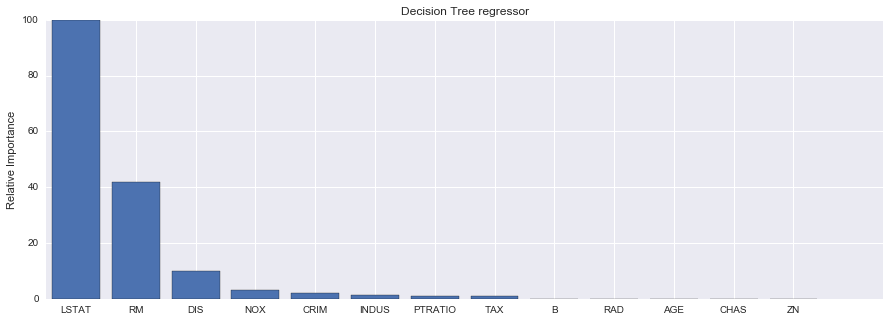

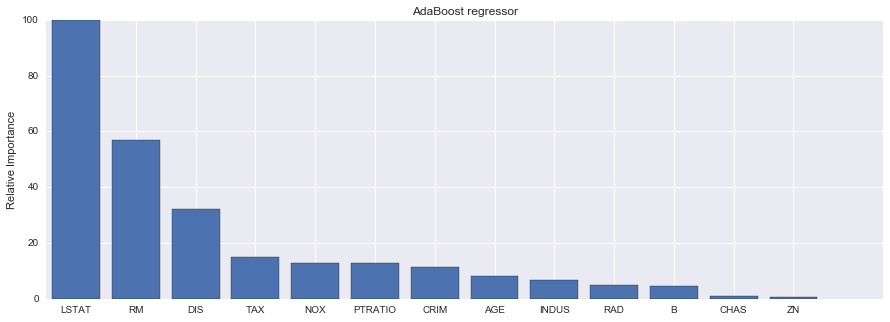

In [235]:
plot_feature_importances(dtRegressor.feature_importances_, 
        'Decision Tree regressor', housing_data.feature_names)
plot_feature_importances(abRegressor.feature_importances_, 
        'AdaBoost regressor', housing_data.feature_names)

In [200]:
# From above data it is clear that most important feature to our model is LSTAT feature. 

****
### 10: Estimating Price of Bicycle. 
We will use a different regressor for this model and it is called the "Random Forest Regressor".A random forest is a collection of decision trees. This basically uses a set of decision trees that are built using various subsets of the dataset, and then it uses averaging to improve the overall performance.

In [255]:
# Libraries are already imported,
# Let us load the data
file = csv.reader(open('bike_hour.csv', 'rb'), delimiter= ',')
# Get the data into X and y 
X, y  = [], []
for rec in file:
    X.append(rec[2:14])
    y.append(rec[-1])
features = np.array(X[0])  # All feature names are in header 
# drop first row as it contain header info, convert all data into float
X, y  = np.array(X[1:]).astype(np.float32) , np.array(y[1:]).astype(np.float32)

# Shuffle the data set so the data will not be in same order
X, y = shuffle(X, y, random_state=7)

# Split the data into train and test
num_training = int(0.9 * len(X))
X_train, y_train = X[:num_training], y[:num_training]
X_test, y_test = X[num_training:], y[num_training:]

In [256]:
# Let us create our model
rfModel = RandomForestRegressor(n_estimators=1000, max_depth=10, min_samples_split=1)
rfModel.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=1, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

Here, n_estimators refers to the number of estimators, which is the number of decision trees that we want to use in our random forest. The max_depth parameter refers to the maximum depth of each tree, and the min_samples_split parameter refers to the number of data samples that are needed to split a node in the tree.

In [257]:
# Metrics/ Model Performance
y_pred_rf = rfModel.predict(X_test)
print 'EVS = ', sm.explained_variance_score(y_test, y_pred_rf)

EVS =  0.918401514296


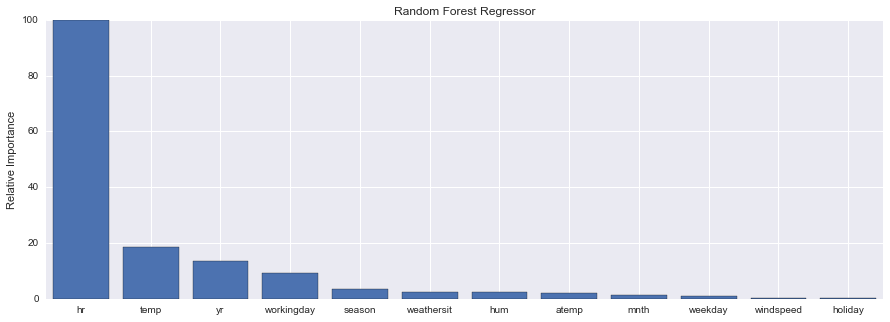

In [258]:
# We can try to use our earlier plot function and see what features are important to our model
plot_feature_importances(rfModel.feature_importances_, 'Random Forest Regressor', features)

In [259]:
# So thats all from Regresson Models .. 